# Zadanie 1 - MLP Clasificator
### Vypracoval: Andrej Petričko, Oleksandr Lytvyn
Zadanie úlohy:

TODO TODO TODO

## Importy

In [3]:
import numpy as np
import pandas as pd


import wandb
import matplotlib.pyplot as plt
import seaborn as sn

from collections import Counter


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from sklearn.model_selection import train_test_split


import tensorflow as tf


## WandB inicializácia

In [4]:
wandb.init(project='Zadanie1', entity='xpetricko')



wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\petri/.netrc


## Načítanie datasetu


In [5]:
train = pd.read_csv("./data/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test = pd.read_csv("./data/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analýza datasetu

In [7]:
z_train = Counter(train['label'])
z_train

Counter({1: 4684,
         0: 4132,
         4: 4072,
         7: 4401,
         3: 4351,
         5: 3795,
         8: 4063,
         9: 4188,
         2: 4177,
         6: 4137})

/Users/MacBook/Documents/python/nsiete_zadanie1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

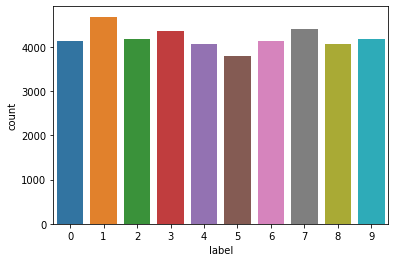

In [6]:
sn.countplot(train['label'])

In [ ]:
# plt.imshow(train.values[1].reshape((28,28)),interpolation='nearest', cmap=plt.cm.gray)
# plt.title("Digit Label: %d" % y_train[1])
# plt.show()

In [4]:
print("Max pixel value: ",np.max(train.values[1]))
print("Min pixel value: ",np.min(train.values[1]))


Max pixel value:  255
Min pixel value:  0


## Predspracovanie dát
Rozdelenie dát a labelov

In [9]:
x_train_np = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train_np = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits


Hodnoty pixelom sú na intervale 0 až 255 a preto bude vhodné ich normalizovať na hodnoty z intervalu 0 až 1.

In [10]:
x_train_np = x_train_np/255.0
print("Max pixel normalized value: ",np.max(x_train_np[0]))
print("Min pixel normalized value: ",np.min(x_train_np[0]))


Max pixel normalized value:  1.0
Min pixel normalized value:  0.0


Transformácia výstupných hodnôt na one hot encoding.

In [44]:
y_train_np_1h = np.eye(10)[y_train_np]
y_train_np_1h

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Rozdelenie na trénovaciu a validačnú sadu

In [27]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(x_train_np, y_train_np, test_size=1/6, random_state=42)

print('train image shape : ', X_train.shape)
print('train label shape : ', y_train.shape)
print('valid image shape : ', X_valid.shape)
print('valid label image : ', y_valid.shape)
print('Whole dataset size : ', x_train_np.shape)

train image shape :  (35000, 784)
train label shape :  (35000,)
valid image shape :  (7000, 784)
valid label image :  (7000,)
Whole dataset size :  (42000, 784)


Rozdelenie na minibatche

In [16]:
#TODO
train_loader = DataLoader(dataset=None,batch_size=128)

##PyTorch MLP Clasificator

In [23]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200,10)
        )

    def forward(self, x):
        # x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

c:\users\petri\nsiete_zadanie1\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


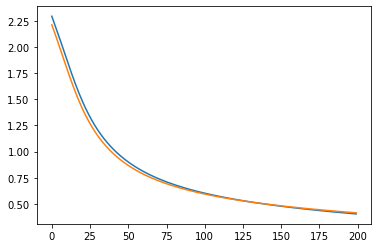

In [45]:
model_torch = Model()
optimizer = torch.optim.Adam(model_torch.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


config = wandb.config
config.learning_rate = 0.01
wandb.watch(model_torch)


train_losses = []
valid_losses = []
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 200



#Aby rôzne modely začínaly s rovnakými inicializovanými váhami
torch.manual_seed(10)

for epoch in range(epochs):
    model_torch.train()


    optimizer.zero_grad()
    output=model_torch(torch.Tensor(X_train)) # (data)
    loss = loss_fn(output,torch.Tensor(y_train).type(torch.LongTensor)) # (Output, target)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
        # Some print if wanted

    model_torch.eval()
    correct = 0
    total = 0
    with torch.no_grad():
            output = model_torch(torch.Tensor(X_valid)) # Data
            loss = loss_fn(output,torch.Tensor(y_valid).type(torch.LongTensor)) #outputs, target

            valid_losses.append(loss.item())


    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))

    # accuracy = 100*correct/total
    # valid_acc_list.append(accuracy)


plt.plot(mean_train_losses)
plt.plot(mean_valid_losses)
plt.show()






In [ ]:
# Kód na inšpiráciu
model_torch = Model()
optimizer = torch.optim.Adam(model_torch.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()



mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 15

for epoch in range(epochs):
    model_torch.train()

    train_losses = []
    valid_losses = []
    for i, (images, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        outputs = model_torch(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (i * 128) % (128 * 100) == 0:
            print(f'{i * 128} / 50000')

    model_torch.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            valid_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))

    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))



### Tensorflow

In [ ]:
#TODO tensor implmentation